In [174]:
from __future__ import division
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Introduction
The aims of Monte Carlo methods are to solve one or both of the following problems:
+ Problem 1: to generate samples $\{x^r\}^R_{r=1}$ form a given probability distribution $p(x)$
+ Problem 2: to estimate expectations of functions under this distribution, for example:

$$\int f(x)p(x)dx$$

Why is sampling from $p(x)$ hard?
+ The first is that we typically do not know the **normalizing** constant $Z$.
+ The second is that, even if we did know $Z$, the problem of drawing samples from $p(z)$ is still a challenging one, especially in **high-dimensional** spaces. 

##Reject sampling

Suppose we wish to sample from a distribution $p(z)$ that is not one of the simple, standard distributions,and that sampling directly form $p(z)$ is difficult.Furthermore suppose, that we are easily able to evaluate $p(z)$ for any given value of $z$, up to som e normalizing constant $Z$,so that 

$$ p(z) = {1 \over Z_p}\widetilde{p}(z)$$

In order to apply rejection sampling, we need some simpler distribution $q(z)$,sometimes called aproposal distribution, from which we can readily draw samples.

$$kq(z) \ge \widetilde{p}(z)$$



<img  src="images/Sampling/FE3RX04YDNGHHVUH3GPX3664LR1TBMPH.png" width="50%"/>

First, we generate a number  $z_0$ from the distribution $q(z)$. Next, we generate a number $u_o$ from the uniform distribution over $[0,kq(z_0)]$. This pair of random numbers has uniform distribution under the curve of the function $kq(z)$. Finally, if $u_0 >p(z_0)$then the sample is rejected, otherwise $u0$ is retained.

<img  src="images/Sampling/UEEA0230F913LVRD3CCB5KL2JRN8OB2C.png" width=70%/>

### Example
For example, suppose we want to sample form a **Gamma** distribution:

$$Ga(x\vert \alpha, \lambda) = {1 \over \Gamma}x^{\alpha-1}\lambda^\alpha \exp(-\lambda x)$$

One can show that if $X_i \sim Expon(\lambda)$, and $Y = X_1 + ... + X_k$, then $Y \sim Ga(k, \lambda)$. For non-integer shape parameters, we can use **rejection sampling** using a $Ga(k,\lambda-1)$ distribution as a proposal, where $k = \lfloor \alpha \rfloor$. The ratio has the form

<img  src="images/Sampling/U4OU54FLJRPR25GYV8YUXV6BS0C56WW9.png"/>

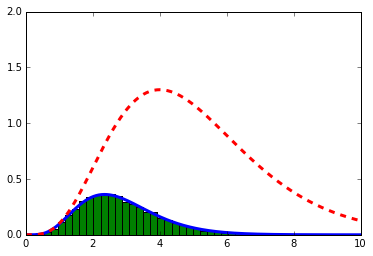

In [200]:
from scipy.stats import gamma
alpha = 5.7
lambda_value = 2
k = floor(alpha)
M = gamma.pdf(alpha-k, alpha, scale=1/lambda_value) / \
    gamma.pdf(alpha-k, k, scale=1/(lambda_value-1))

xs = linspace(0, 10, 1001)

plt.figure()
plt.axis([0,10,0,2])
plt.plot(xs, gamma.pdf(xs, alpha, scale=1/lambda_value), linewidth=3)
plt.plot(xs, M * gamma.pdf(xs, k, scale=1/(lambda_value-1)), 'r--', linewidth=3)

N = 100000
xs_cand = gamma.rvs(k,scale=1/(lambda_value-1), size=N)

sample_values = M * gamma.pdf(xs_cand, k, scale=1/(lambda_value-1)) * random.random(N)
target_values = gamma.pdf(xs_cand, alpha, scale=1/lambda_value)
accept_values = xs_cand[np.nonzero(target_values > sample_values)[0]]

n, bins, rectangle = plt.hist(accept_values, 50, normed=True)


###Adaptive rejection sampling
If $p(x)$ is **log concave**, we can construct an **envelope function**. We choose the initial locations for the pieces based on a fixed grid over the support of the distribution. We then evaluate the gradient of the log density at these locations, and make the lines be tangent at these points.

$$q(x) = M_i \lambda_i \exp(- \lambda_i(x_i - x_{i-1})), \      x_{i-1} \lt x \le x_i$$

where $x_i$ are the grid points.

<img  src="images/Sampling/VSE3N1BPQG7N8O3UJYI9PFKN9JYOR9WP.png" width="50%"/>

##Importance sampling
Importance sampling is a Monte Carlo method for approximating integrals of the form 

$$I = E[f] = \int f(x)p(x)dx$$

The idea is to draw samples $x$ in regions which have high probability, $p(x)$, but also where $\vert f(x) \vert$ is large. The result can be **super efficient**, meaning it needs less samples than if we were to sample from the exact distribution $p(x)$. The reason is that the samples are focussed on the important parts of space. For example, suppose we want to estimate the probability of a rare event. Define $f(x)=I(x \in E)$, for some set $E$. Then it is better to sample from a proposal of the form $q(x)\propto f(x)p(x)$ than to sample from $p(x)$ itself.

$$E[f] = \int f(x) {p(x)\over q(x)}q(x)dx \approx {1\over S} \sum^S_{s=1}w_sf(x^s)$$

where $w_s\triangleq {p(x^s) \over q(x^s)}$ are the **importance weights**.

**optimal importance distribution**:

$$q^* = {\lvert f(x) \rvert p(x) \over \int \lvert f(x) \rvert p(x)dx}$$

## MCMC

###Markov chain
For any starting point, the chain will convergence to the invariant distribution $p(x)$, as long as $T$ is a stochastic transition matrix that obeys the following properties:
1. **Irreducibility**. For any state of the Markov chain, there is a positive probability of visiting all other states. That is, the matrixTcannot be reduced to separate smaller matrices, which is also the same as stating that the transition graph is connected.
2. **Aperiodicity**. The chain should not get trapped in cycles.

A **sufficient, not necessaty** condition to ensure that a particular $p(x)$ is the desired invariant distribution is the following reversibility(**detailed balance**) condition:

$$p(x^i)T(x^{i-1} \vert x^i) = p(x^{i-1})T(x^i \vert x^{i-1})$$

Summing both sides over $x^{i-1}$, give us

$$p(x^i) = \sum_{x_{i-1}} p(x^{i-1}) T(x^i \vert x^{i-1})$$

In continuous state spaces, the transition matrix $T$ becomes an integral kernel $K$ and $p(x)$ becomes the corresponding eigenfunction

$$p(x^i) = \int p(x^{i-1}) K(x^{i} \vert x^{i-1})) dx^i$$

### Metropolis-Hastings algorithm
An MH step of invariant distribution $p(x)$ and proposal distribution $q(x^* \mid x)$ involves sampling a candidate value $x^*$ given the current value $x$ according to $q(x^* \mid x)$. The Markov chain then moves towards $x^*$ with acceptance probability $A(x, x^*) = min\{ 1, {p(x^*)q(x \mid x^*) \over p(x)q(x^* \mid x)}\}$, otherwise it remains at $x$.

<img  src="images/Sampling/PPQUSGQ1NYEG766UTUM8K34SY23JYS1G.png"/>

The transition kernel for the MH algorithm is

$$K_{MH}(x^{i+1} \mid x^i) = q(x^{i+1} \mid x^i) A(x^{i}, x^{i+1}) + \delta_{x^i}(x^{i+1}r(x^I))$$

where

$$r(x^i) = \int_{\mathcal X} q(x^* \mid x^i) (1-A(x^i, x^*))dx^*$$

By construction, $K_{MH}$ satisfies the detailed **balance condition**

Some properties of the MH algorithm are worth highlighting:
+ Firstly, the **normalising constant** of the target distribution is **not required**. We only need to know the target distribution
up to a constant of proportionality. 
+ Secondly, although the pseudo-code makes use of a single chain, it is easy to simulate several independent chains in **parallel**.
+ Different choices of the proposal distribution lead to very different results. if the proposal is **too narrow**, only one mode of $p(x)$ might be visited. On the other hand, if it is **too wide**, the rejection rate can be very high, resulting in high correlations. if all the modes are visited while the acceptance probability is high, the chain is said to **mix** well

**Example**:
A bimodal target distribution $p(x) \propto 0.3\exp(-0.2x^2) + 0.7\exp(-0.2(x-10)^2)$ with a Gaussian proposal distribution $q(x^* \mid x^i) = \mathcal N(x^i, \sigma^2)$


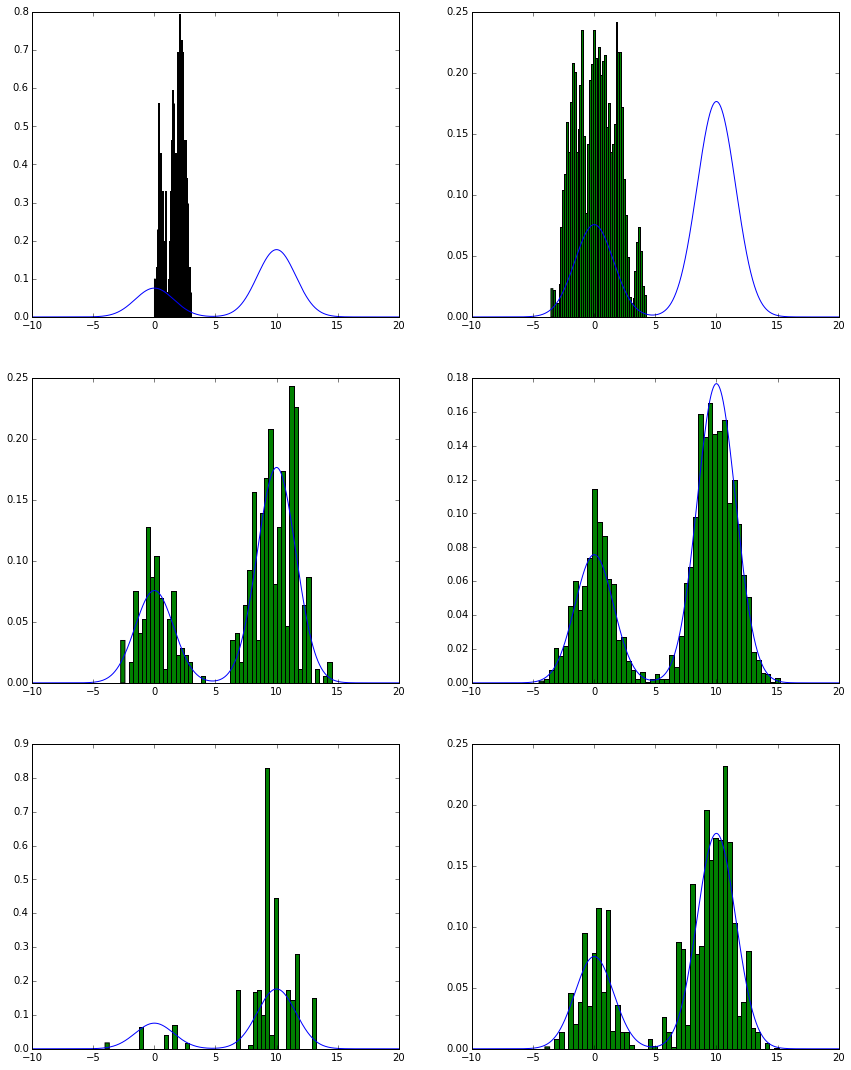

In [276]:
from scipy.stats import norm

def metropolis_algorithm(T, p, q, q_sample):
    accept_values = np.zeros(T)
    accept_values[0] = random.random()
    for i in xrange(0,T-1):
        u = random.random()
        x_cand = q_sample(accept_values[i])
        if u < min(1, p(x_cand) * q(accept_values[i], x_cand) / \
                       (p(accept_values[i]) * q(x_cand, accept_values[i]))):
            accept_values[i+1] = x_cand
        else:
            accept_values[i+1] = accept_values[i]
    return accept_values

N = 10000
NORM_CONSTANT = 3.96333
p = lambda x: (0.3 * exp(-0.2 * x ** 2) + \
                0.7 * exp(-0.2 * (x-10) ** 2)) / NORM_CONSTANT

xs = linspace(-10, 20, N + 1)
p_values = p(xs)
    
#print (p_values * 30 / N).sum()

T = 5000
STD = [0.1, 10 , 100]

fig = plt.figure(1, (16,20))
gs = GridSpec(3,2,bottom=0.18,left=0.18,right=0.88)
for i, std in enumerate(STD):
    q = lambda x, x_cond: norm.pdf(x, loc=x_cond, scale=std)
    q_sample = lambda x_cond: norm.rvs(loc=x_cond, scale=std)
    
    accept_values = metropolis_algorithm(T, p, q, q_sample)
    
    ax = fig.add_subplot(gs[i,0])
    ax.plot(xs, p_values)
    n, bins, rectangle = ax.hist(accept_values[:500], 50, normed=True)
    
    ax = fig.add_subplot(gs[i,1])
    ax.plot(xs, p_values)
    n, bins, rectangle = ax.hist(accept_values, 50, normed=True)


A very powerful property of MCMC is that it is possible to combine several samplers into mixtures and cysles of the individual samplers. If the transition kernels $K_1$ and $K_2$ have invariant distribution $p(x)$, then the **cycle hybrid kernel** $K_1K_2$ and the **mixture hybrid kernel** $vK_1 + (1-v)K_2$, for $0 \le v \le 1$, are also transition kernels with invariant distribution $p(x)$
Cycles allow us to split a multivariate state vector into components (blocks) that can be
updated separately.


###Gibbs sampling
Suppose we have an n-dimensional vector $x$ and the expressions for the full conditionals $p(x_j \mid x_1,...,x_{j-1},x_{j+1},...,x_n)$. In this case, it is often advantageous to use the following proposal distribution for $j = 1,...n$

$$q(x^* \mid x^i) = 
\begin{cases}
p(x^*_j \mid x^i_{-j}) & \text{if $x^*_{-j}=x^i_{-j}$} \\
0 & \text{Otherwise} 
\end{cases}$$

The corresponding acceptance probability is:

$$\begin{align}
A(x^i, x^*)  &= \min\{1, {p(x^*)q(x^i \mid x^*) \over p(x^i)q(x^* \mid x^i)}\} \\
&= \min \{1, {p(x^*)p(x^i_j \mid x^i_{-j}) \over p(x^i)p(x^*_j \mid x^*_{-j})}\} \\
&= \min\{1, {p(x^*_{-j}) \over p(x^i_{-j})}\} = 1 
\end{align}$$

<img  src="images/Sampling/JEY1D4ISOOA9FL0NC2UO3MS9P3P4RUG7.png"/>